In [1]:
import pandas as pd

df = pd.read_csv("/content/SupplyChainEmissionFactorsforUSIndustriesCommodities2015_Summary.csv")
display(df.head())

,Industry Code,Industry Name,Substance,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Unnamed: 7,DQ ReliabilityScore of Factors without Margins,DQ TemporalCorrelation of Factors without Margins,DQ GeographicalCorrelation of Factors without Margins,DQ TechnologicalCorrelation of Factors without Margins,DQ DataCollection of Factors without Margins
0,111CA,Farms,carbon dioxide,"kg/2018 USD, purchaser price",Supply Chain Emission Factors without Margins,0.041,0.465,NaN,4,2,1,4,1
1,111CA,Farms,methane,"kg/2018 USD, purchaser price",0.023,0.000,0.023,NaN,3,2,1,1,1
2,111CA,Farms,nitrous oxide,"kg/2018 USD, purchaser price",0.002,0.000,0.002,NaN,4,2,1,4,1
3,111CA,Farms,other GHGs,"kg CO2e/2018 USD, purchaser price",0.004,0.000,0.004,NaN,3,2,1,4,1
4,113FF,"Forestry, fishing, and related activities",carbon dioxide,"kg/2018 USD, purchaser price",0.184,0.017,0.201,NaN,4,2,1,4,1


In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

df_cleaned = df.drop(columns=['Unnamed: 7']).copy()

df_cleaned = df_cleaned.iloc[1:].copy()

numeric_cols = ['Supply Chain Emission Factors without Margins', 'Margins of Supply Chain Emission Factors', 'Supply Chain Emission Factors with Margins']

for col in numeric_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].mean())
df_cleaned = df_cleaned.dropna()

X = df_cleaned[['Supply Chain Emission Factors without Margins', 'Margins of Supply Chain Emission Factors']]
y = df_cleaned['Supply Chain Emission Factors with Margins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models = {
    "Linear Regression": linear_reg_model,
    "Decision Tree": decision_tree_model,
    "Random Forest": random_forest_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

results_df = pd.DataFrame(results).T
display(results_df)

,RMSE,MAE,R2
Linear Regression,0.000145,0.000037,1.000000
Decision Tree,0.290018,0.043212,0.620431
Random Forest,0.316923,0.046992,0.546740


In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_random_forest_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


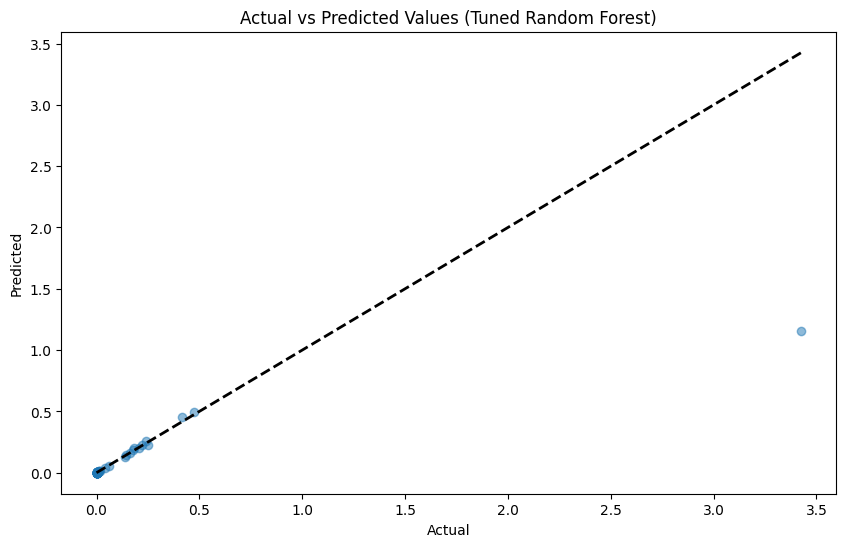

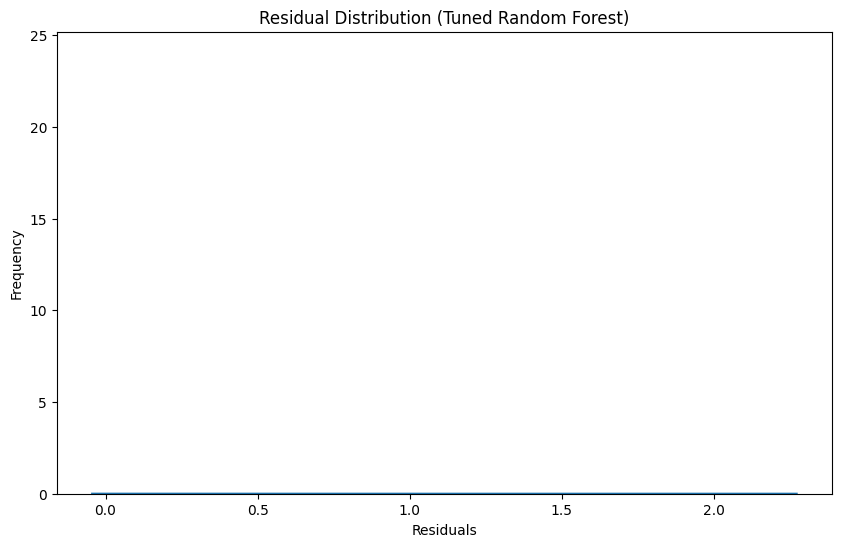

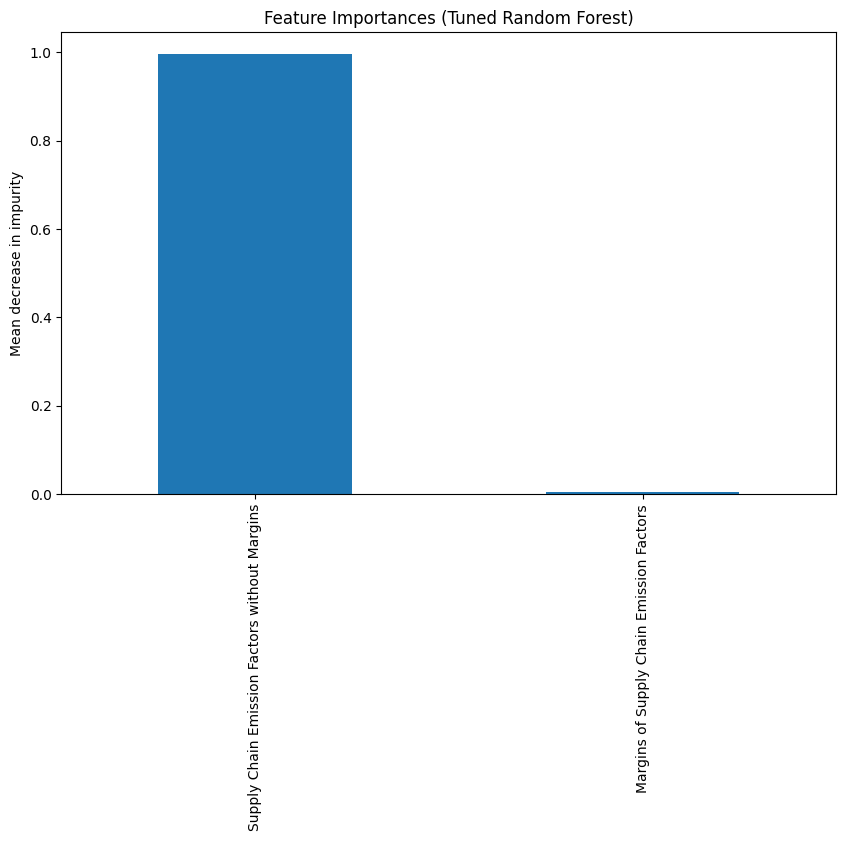

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize actual vs predicted values for the tuned Random Forest model
y_pred_tuned = best_random_forest_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values (Tuned Random Forest)")
plt.show()

# Visualize residual distribution for the tuned Random Forest model
residuals = y_test - y_pred_tuned
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Tuned Random Forest)")
plt.show()

# Visualize feature importance for the tuned Random Forest model
if hasattr(best_random_forest_model, 'feature_importances_'):
    importances = best_random_forest_model.feature_importances_
    feature_names = X_train.columns
    forest_importances = pd.Series(importances, index=feature_names)

    plt.figure(figsize=(10, 6))
    forest_importances.plot.bar()
    plt.title("Feature Importances (Tuned Random Forest)")
    plt.ylabel("Mean decrease in impurity")
    plt.show()

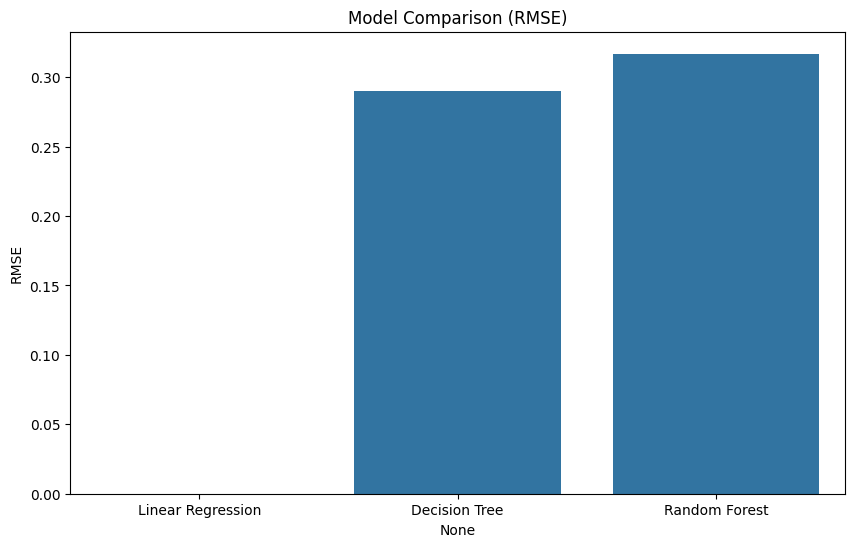

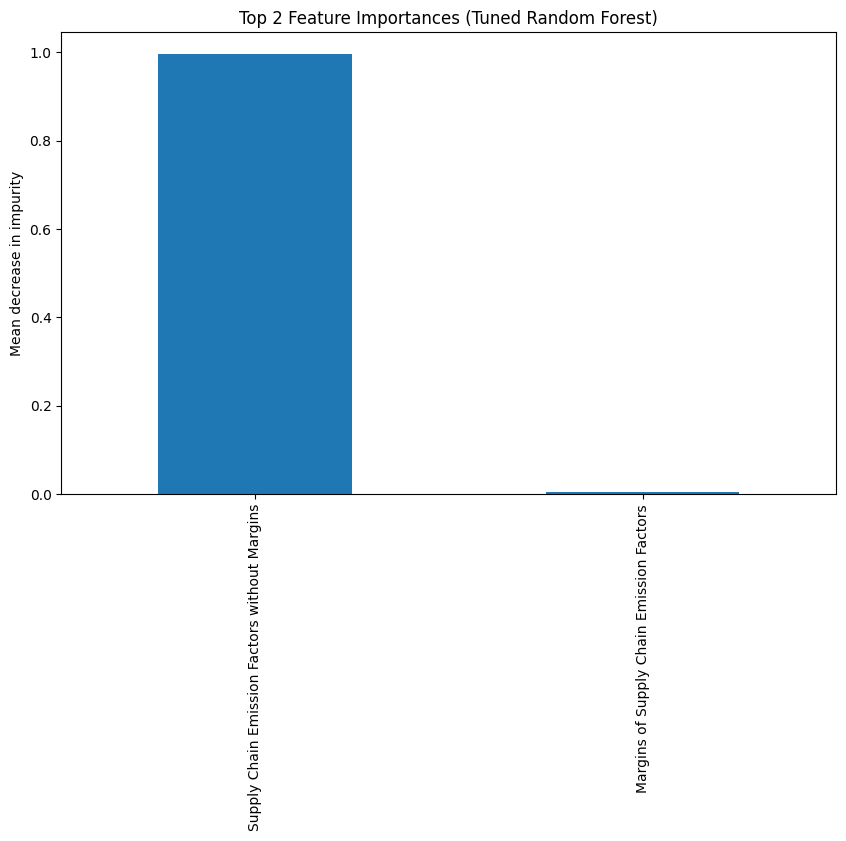

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize model comparison - RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['RMSE'])
plt.ylabel("RMSE")
plt.title("Model Comparison (RMSE)")
plt.show()

# Visualize top 10 feature importances for the tuned Random Forest model
if hasattr(best_random_forest_model, 'feature_importances_'):
    importances = best_random_forest_model.feature_importances_
    feature_names = X_train.columns
    forest_importances = pd.Series(importances, index=feature_names)

    # Get top 10 features (in this case, there are only 2 features)
    top_n = 10
    if len(forest_importances) > top_n:
        forest_importances = forest_importances.nlargest(top_n)

    plt.figure(figsize=(10, 6))
    forest_importances.plot.bar()
    plt.title(f"Top {len(forest_importances)} Feature Importances (Tuned Random Forest)")
    plt.ylabel("Mean decrease in impurity")
    plt.show()

In [15]:
import joblib

joblib.dump(best_random_forest_model, 'best_random_forest_model.pkl')
print("Tuned Random Forest model saved as 'best_random_forest_model.pkl'")

Tuned Random Forest model saved as 'best_random_forest_model.pkl'


In [16]:
df_cleaned.to_csv('preprocessed_data.csv', index=False)
print("Preprocessed data saved to 'preprocessed_data.csv'")

Preprocessed data saved to 'preprocessed_data.csv'
